In [1]:
# packages needed:
    ## torch
    ## torchvision
    ## numpy
    ## matplotlib
    ## tqdm

In [2]:
# imports needed
import torch
torch.manual_seed(0)
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# helper functions
# This plots the distribution on a graph to see how the different images are grouped by classification
def plot_seperation(autoencoder, data, num_batches = 100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to('cpu'))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

# This function creates images along input ranging from -5 to 5 for both inputs.
# This allows us to preview the changes as the inputs change
def plot_reconstructed(autoencoder, r0=(-5, 5), r1=(-5, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cpu')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gray', interpolation='none')

In [3]:
# load the MNSIT handwritten data
# Transform the data to tensors (this allows us to train)
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../files/', train=True, download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
    batch_size=128, shuffle=True)

torch.Size([128, 1, 28, 28])


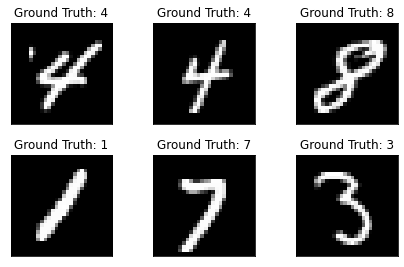

In [4]:
# Preview what the images look like
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [5]:
# Encoder class
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # flatten the input (for our case, it will always be 28x28x1)
        self.flatten = nn.Flatten()

        # The input of a linear function is input size and output size
        # Our input is 28*28*1 since that is the dimension of our images.
        # 512 for the output was choosen arbitraily. You can change it to see how it effects the output
        self.linear1 = nn.Linear(28*28*1, 512)

        # Input must be the same size as the output of the previous layer
        # we are outputing to 2 dims to make it easier to visualize how they are grouped
        self.linear2 = nn.Linear(512, 2)

    # This function runs the different layers
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


In [6]:
# Decoder class
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Input for this layer is 2
        # Output is choosen to be 512 arbitarily
        self.linear1 = nn.Linear(2, 512)

        # Input must be the same size as the output of previous layer
        # We want the output to be the same size as the flattened image
        self.linear2 = nn.Linear(512, 28*28*1)

        # We want to unflatten the image at the end so we can plot it.
        self.unflatten = nn.Unflatten(1, (1, 28, 28))

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return self.unflatten(x)

In [7]:
# The autoencoder class to wrap the Encoder and Decoder into
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# Set up an autoencoder to use
autoencoder = Autoencoder()

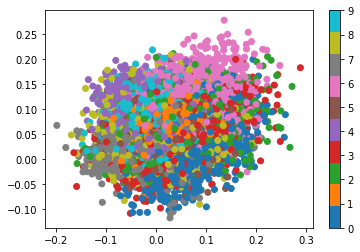

In [9]:
# See how encoder seperates value initially
# We can see that the value are pretty mixed together
plot_seperation(autoencoder, train_loader)

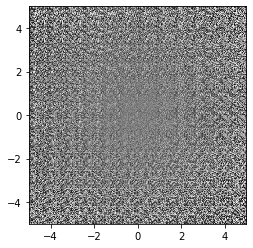

In [10]:
# see how the output looks right prior to training
# As expected it looks like a bunch of random noise
plot_reconstructed(autoencoder)

In [11]:
# Train the autoencoder

# Numbers of epochs to train for
epochs = 20

# The optimizer to use, this informs the model on how to learn
opt = torch.optim.Adam(autoencoder.parameters())

for i in range(1, epochs + 1):
    for x, y in tqdm(train_loader, 'Epoch {}/{}'.format(i, epochs)):
        x = x.to('cpu') # train on cpu

        # zero out optimizer prior to each batch
        opt.zero_grad()

        # use the autoencoder to predict what a reconstructed image looks like
        x_hat = autoencoder(x)

        # Compure loss, this is Mean square error
        loss = ((x - x_hat)**2).sum()

        # propagate the loss backwards
        loss.backward()

        # step the optimizer
        opt.step()

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

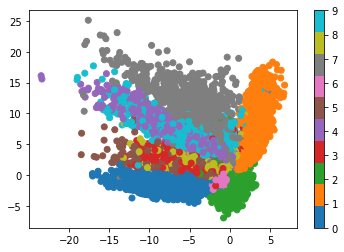

In [12]:
# see how encoder seperates values after training
# We can see that the different numbers are now grouped together
plot_seperation(autoencoder, train_loader)

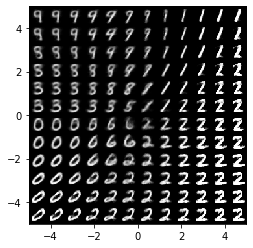

In [13]:
# see how the decoder part of the autoencoder recreates the images
plot_reconstructed(autoencoder)